# Ablauf

1) Daten einlesen
2) Daten aufebereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    -   Scatterplot Jobs auf Watt + Regression
    -   line chart auf bar chart
    -   Berechnung pro Worker - Idle

# 1. Daten einlesen

### CSV einlesen

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats.mstats import winsorize

#read Worker Power CSV
worker_power = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels


#read Worker: Jobs Finished CSV
worker_jobs_finished = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Jobs.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Started CSV
worker_jobs_started = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Jobs Started.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels


#read Zeebe gRPC CSV
zeebe_grpc = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Zeebe grpc.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read Zeebe Job Creation CSV
zeebe_job_creation = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Zeebe Job Creation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read Zeebe Job Completion CSV
zeebe_job_completion = pd.read_csv("CSV-mja/2024-02-10 10-46-00 mja2.sh Zeebe Job Completion.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels


In [114]:
LOG_PATH = "shell-scripts/logs/mja/"
LOG_NAME_LOW = "mja2.sh-2024-02-10-23-00-00-load_generator_8x60_parallel-mja-8"
LOG_NAME_MED = "mja2.sh-2024-02-10-16-25-00-load_generator_8x60_parallel-mja-64"
LOG_NAME_HIGH = "mja2.sh-2024-02-10-10-46-00-load_generator_8x60_parallel-mja-1024"

# read all 3 log file of START times

def read_start_times(LOG_PATH,LOG_NAME):
    start_times = []

    with open(LOG_PATH+LOG_NAME, "r") as file:
        start_times = file.readlines()

    # remove newline-character, 
    for i, time in enumerate(start_times):
        start_times[i] = time[:-1]

    return start_times

start_times_low = read_start_times(LOG_PATH,LOG_NAME_LOW)
start_times_med = read_start_times(LOG_PATH,LOG_NAME_MED)
start_times_high = read_start_times(LOG_PATH,LOG_NAME_HIGH)

# 2. Daten aufbereiten

1) Addiere alle Messwerte von Kepler
2) Generiere Leerlauf-Muster
3) Subtrahiere Leerlauf-Muster

4) Vereine Completion und Power
5) Generiere Durchsatz-Buckets
6) Berechne Outlier pro Bucket

### Messwerte aus Kepler einlesen und summieren

In [115]:
completion_and_power = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power['power'] = worker_power[worker_cols].sum(axis=1)

### Durchsatzwerte aus Worker, Zeebe und gRPC einlesen

In [116]:
completion_and_power['jobs_started'] = worker_jobs_started['worker'] // 1
completion_and_power['jobs_finished'] = worker_jobs_finished['worker'] // 1
completion_and_power['jobs_open'] = completion_and_power['jobs_started'] - completion_and_power['jobs_finished']
completion_and_power['grpc_activation_ok'] = zeebe_grpc['ActivateJobs (OK)']
completion_and_power['grpc_activation_exhausted'] = zeebe_grpc['ActivateJobs (RESOURCE_EXHAUSTED)']
completion_and_power['grpc_activation_total'] = completion_and_power['grpc_activation_ok'] + completion_and_power['grpc_activation_exhausted']
completion_and_power['grpc_completion_ok'] = zeebe_grpc['CompleteJob (OK)']
completion_and_power['zeebe_job_creation'] = zeebe_job_creation['Job creation camunda8']
completion_and_power['zeebe_job_completion'] = zeebe_job_completion['Job completion camunda8']

### Generiere Leerlauf-Muster + Subtrahiere Leerlauf-Muster

In [117]:
# set all completion >= 1 to NaN

idle_power = completion_and_power.copy()
idle_power[(idle_power['jobs_started'] >= 1) & (idle_power['jobs_finished'] >= 1)] = np.nan


# generate medians for 00:00, 00:10, 00:20

# reshape series
idle_pattern = pd.DataFrame(idle_power['power'][:-1].to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

medians = idle_pattern.median(axis=0)

medians


00:00    0.1853
00:10    0.1377
00:20    0.1383
dtype: float64

In [118]:
def remove_idle_power(df, pattern):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)
    
    print(difference)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df['no_idle'] = df['power'] - pattern_series
    df['idle'] = pattern_series


    return df

cap_no_idle = remove_idle_power(completion_and_power, medians)
# cap_no_idle = completion_and_power

cap_no_idle 


2


,power,jobs_started,jobs_finished,jobs_open,grpc_activation_ok,grpc_activation_exhausted,grpc_activation_total,grpc_completion_ok,zeebe_job_creation,zeebe_job_completion,no_idle,idle
Time,,,,,,,,,,,,
2024-02-10 10:45:00,0.1879,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0026,0.1853
2024-02-10 10:45:10,0.1555,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0178,0.1377
2024-02-10 10:45:20,0.1409,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0026,0.1383
2024-02-10 10:45:30,0.2023,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0170,0.1853
2024-02-10 10:45:40,0.1433,0.0,0.0,0.0,0.1,NaN,NaN,0.0,0.0,0.0,0.0056,0.1377
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-11 06:00:50,0.1373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.0010,0.1383
2024-02-11 06:01:00,0.1373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.0480,0.1853
2024-02-11 06:01:10,0.1373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-0.0004,0.1377


### Generiere Energieverbrauch pro Job

In [119]:
cap_no_idle['per_job_no_idle'] = cap_no_idle['no_idle'] / cap_no_idle['jobs_started']

### Entferne Zeitpunkte ohne Durchsatz

In [120]:
cap_no_idle = cap_no_idle[(cap_no_idle['jobs_started'] >= 1) & (cap_no_idle['jobs_finished'] >= 1)]

### Teile Messreihen nach Konfiguration


In [121]:
USE_ONLY_FIRST_TWO_PHASES = False

if USE_ONLY_FIRST_TWO_PHASES:
    mja_8 = cap_no_idle.loc[start_times_low[0]:start_times_low[60],:]
    mja_64 = cap_no_idle.loc[start_times_med[0]:start_times_med[60],:]
    mja_1024 = cap_no_idle.loc[start_times_high[0]: start_times_high[60],:]
else:
    mja_8 = cap_no_idle.loc[start_times_low[0]:,:]
    mja_64 = cap_no_idle.loc[start_times_med[0]:start_times_low[0],:]
    mja_1024 = cap_no_idle.loc[start_times_high[0]: start_times_med[0],:]

### Sortiere nach Durchsatz

In [122]:
THROUGHPUT_COLUMN = 'jobs_finished'

l_sorted = mja_8.sort_values(by=THROUGHPUT_COLUMN)
m_sorted = mja_64.sort_values(by=THROUGHPUT_COLUMN)
h_sorted = mja_1024.sort_values(by=THROUGHPUT_COLUMN)
all_sorted = cap_no_idle.sort_values(by=THROUGHPUT_COLUMN)


### Generiere Durchsatz-Buckets pro Job


In [123]:
# Bucket Params

def create_buckets(df, col, bucket_size):

    # create limits for buckets
    max_throughput = int(df[col].max())
    min_throughput = int(df[col].min())
    span_throughput = int(max_throughput - min_throughput)

    # number of buckets
    num_buckets = (span_throughput // bucket_size) + 1

    buckets = [i for i in range(min_throughput ,max_throughput + bucket_size, bucket_size)]
    bucket_labels = [f"{buckets[i]} - {buckets[i+1]}" for i in range(len(buckets) - 1)]

    return buckets, bucket_labels


buckets, bucket_labels = create_buckets(all_sorted, 'jobs_started', 60)



### Sortiere nach Buckets

In [124]:
def group_by_bucket(sorted_df, groupby, grouped_col, bucket_list):
    df_grouped = pd.DataFrame()

    grouped_list = [sorted_df[
            (sorted_df[groupby] >= bucket_list[i]) 
            & 
            (sorted_df[groupby] < bucket_list[i + 1])
            ]
            [grouped_col]
            .reset_index(drop=True) 
            for i in range(len(bucket_list) - 1)]

    temp = pd.concat(grouped_list, axis=1)

    temp.columns = bucket_list[0:len(bucket_list) - 1]

    return temp

In [125]:
l_grouped = group_by_bucket(l_sorted, 'jobs_started', 'no_idle', buckets)
m_grouped = group_by_bucket(m_sorted, 'jobs_started', 'no_idle', buckets)
h_grouped = group_by_bucket(h_sorted, 'jobs_started', 'no_idle', buckets)

### Entferne Ausreißer

In [126]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')


In [127]:
l_clean = filter_outliers_iqr(l_grouped)
m_clean = filter_outliers_iqr(m_grouped)
h_clean = filter_outliers_iqr(h_grouped)

In [128]:
lmh_hist = pd.DataFrame()

lmh_hist['mja8'] = l_clean.count()
lmh_hist['mja64'] = m_clean.count()
lmh_hist['mja1024'] = h_clean.count()

<Axes: title={'center': 'Sample Sizes in Buckets'}>

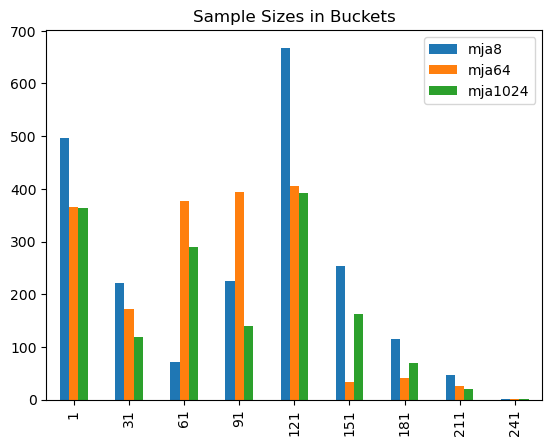

In [129]:
lmh_hist.plot(kind='bar', title='Sample Sizes in Buckets')

### Erstelle Vergleichstabelle
Mediane nach Durchsatz sortiert

In [130]:
hml_median = pd.DataFrame()
hml_median['mja8'] = l_clean.median()
hml_median['mja64'] = m_clean.median()
hml_median['mja1024'] = h_clean.median()

# Plotting

In [131]:
# PLOT SETTINGS

figsize = [9,8]
whis= [0,100]

# LABELS

labels = {
    'power' : 'Energieverbrauch in Watt pro Sekunde',
    'throughput' : 'Jobs pro Sekunde'
}




<Axes: title={'center': 'Energieverbrauch nach Durchsatz im Median'}, xlabel='Jobs pro Sekunde', ylabel='Energieverbrauch in Watt pro Sekunde'>

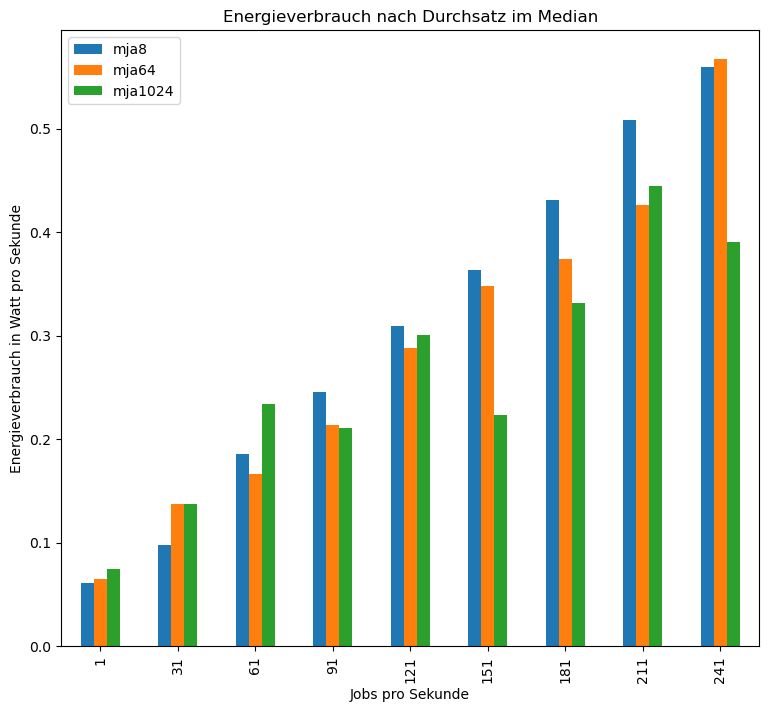

In [132]:
hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median", ylabel=labels['power'], xlabel=labels['throughput'])

<Axes: >

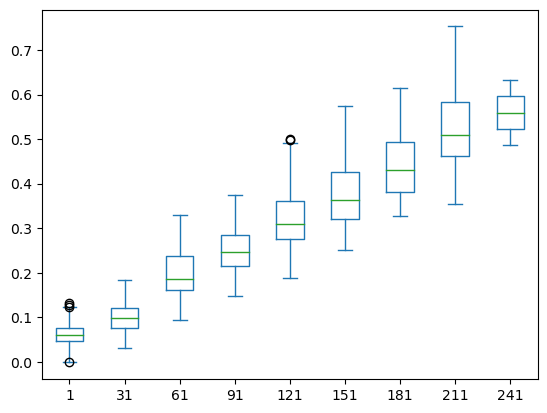

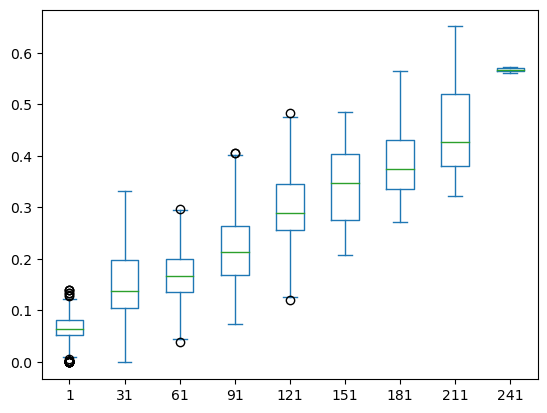

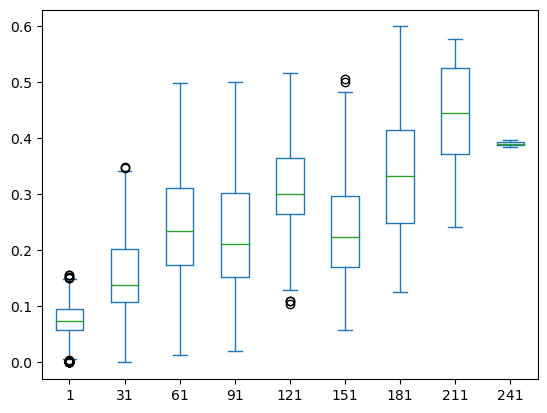

In [133]:
l_clean.plot(kind='box')
m_clean.plot(kind='box')
h_clean.plot(kind='box')

In [134]:
all_sorted.columns

Index(['power', 'jobs_started', 'jobs_finished', 'jobs_open',
       'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'no_idle', 'idle', 'per_job_no_idle'],
      dtype='object')

<Axes: xlabel='grpc_activation_ok', ylabel='no_idle'>

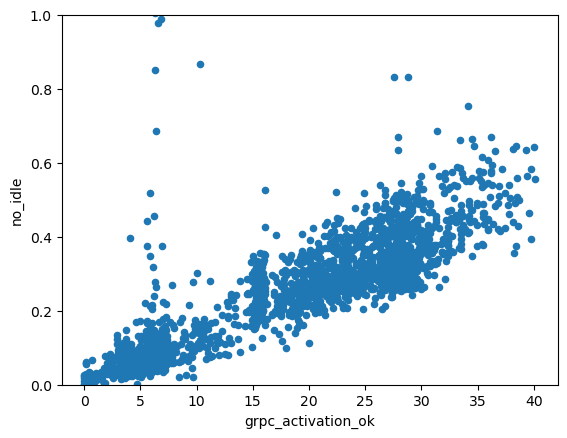

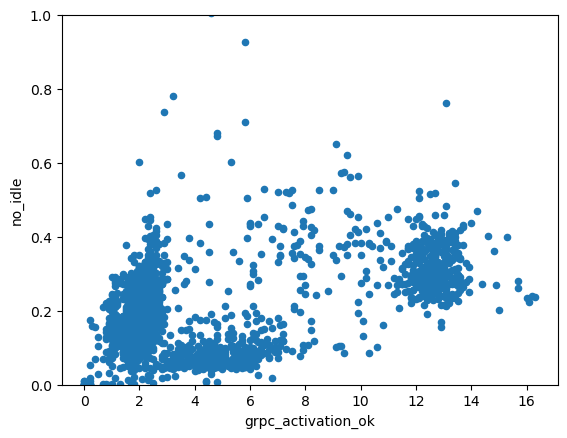

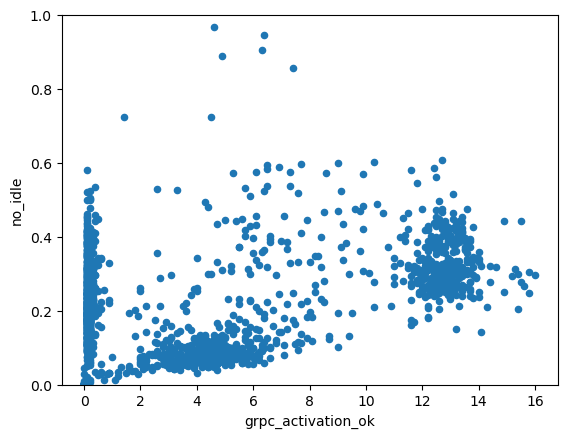

In [135]:
x_scatter = 'grpc_activation_ok'
y_scatter = 'no_idle'
ylim = [0,1]

mja_8.plot(kind='scatter', x=x_scatter, y=y_scatter, ylim=ylim)
mja_64.plot(kind='scatter', x=x_scatter, y=y_scatter, ylim=ylim)
mja_1024.plot(kind='scatter', x=x_scatter, y=y_scatter, ylim=ylim)

### Scatter plots

<Axes: xlabel='zeebe_job_completion', ylabel='jobs_finished'>

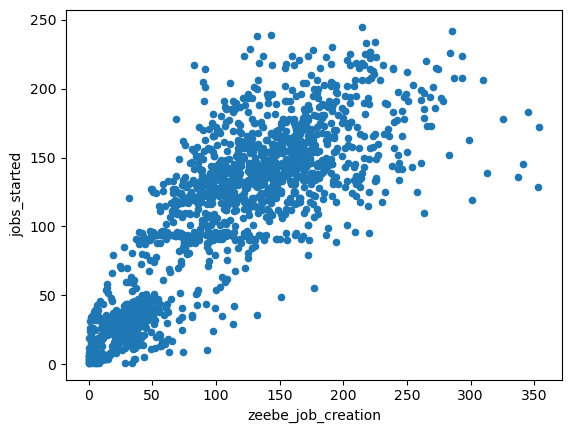

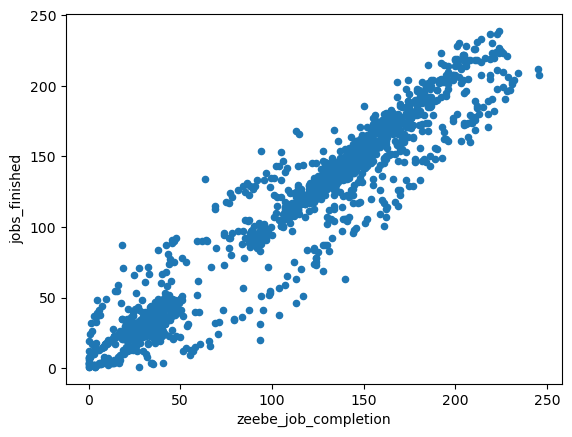

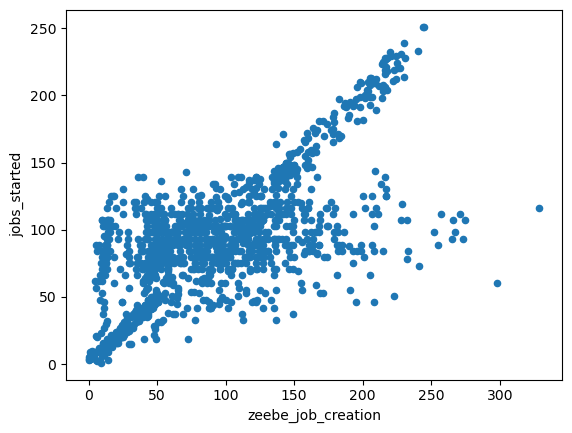

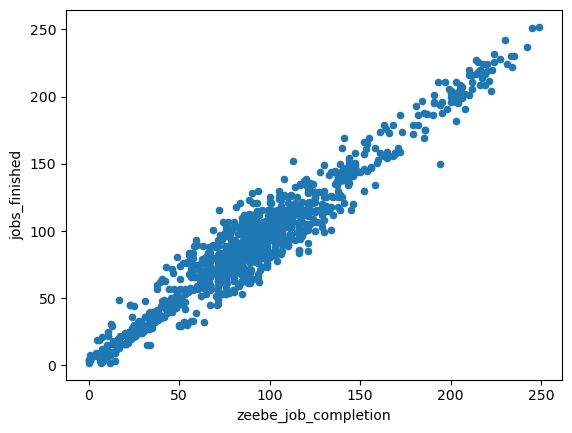

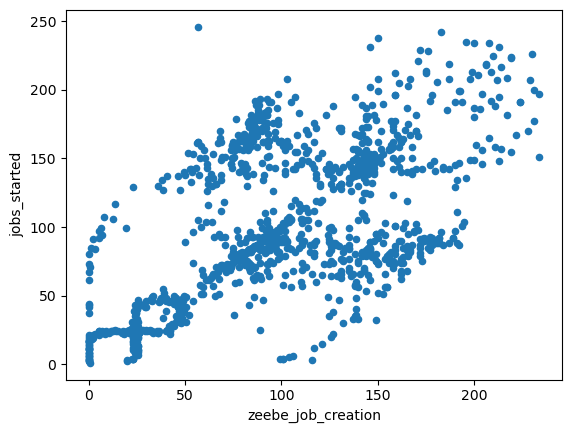

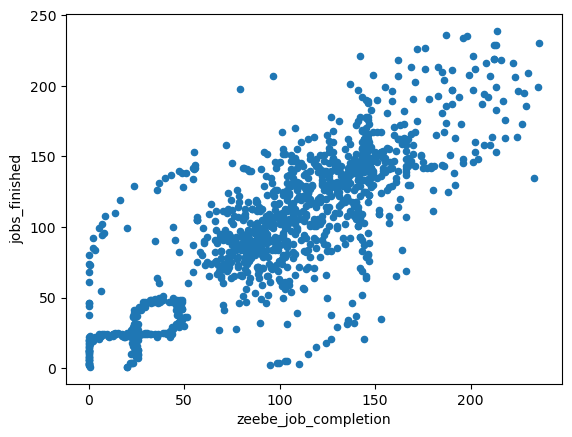

In [136]:
mja_8.plot(kind='scatter', x='zeebe_job_creation', y="jobs_started")
mja_8.plot(kind='scatter', x='zeebe_job_completion', y="jobs_finished")
mja_64.plot(kind='scatter', x='zeebe_job_creation', y="jobs_started")
mja_64.plot(kind='scatter', x='zeebe_job_completion', y="jobs_finished")
mja_1024.plot(kind='scatter', x='zeebe_job_creation', y="jobs_started")
mja_1024.plot(kind='scatter', x='zeebe_job_completion', y="jobs_finished")

<Axes: xlabel='grpc_activation_ok', ylabel='grpc_completion_ok'>

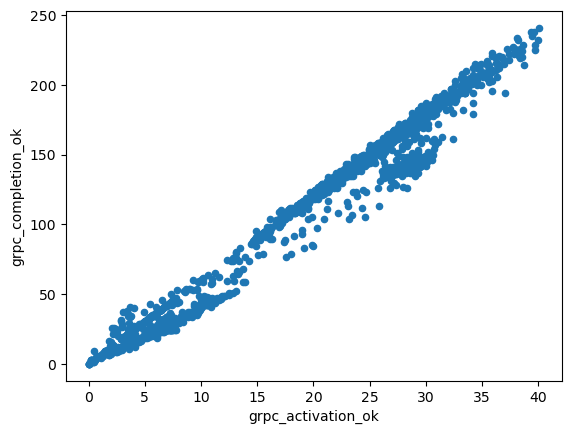

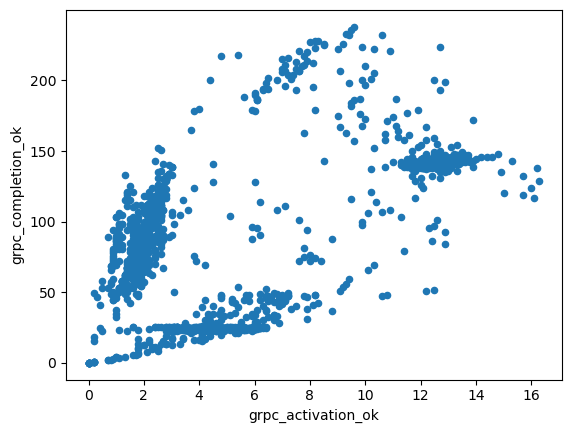

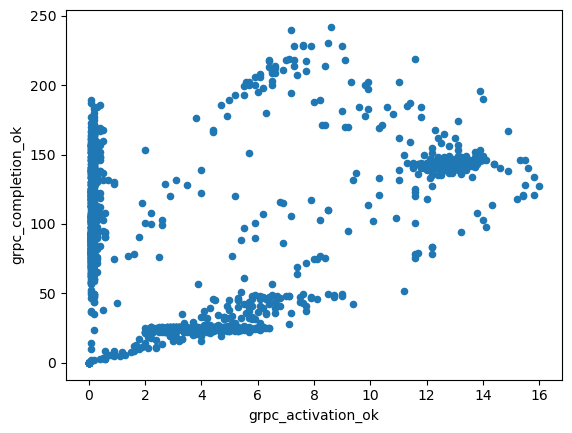

In [137]:
mja_8.plot(kind='scatter', x='grpc_activation_ok', y='grpc_completion_ok')
mja_64.plot(kind='scatter', x='grpc_activation_ok', y='grpc_completion_ok')
mja_1024.plot(kind='scatter', x='grpc_activation_ok', y='grpc_completion_ok')

### ...

<Axes: xlabel='Time'>

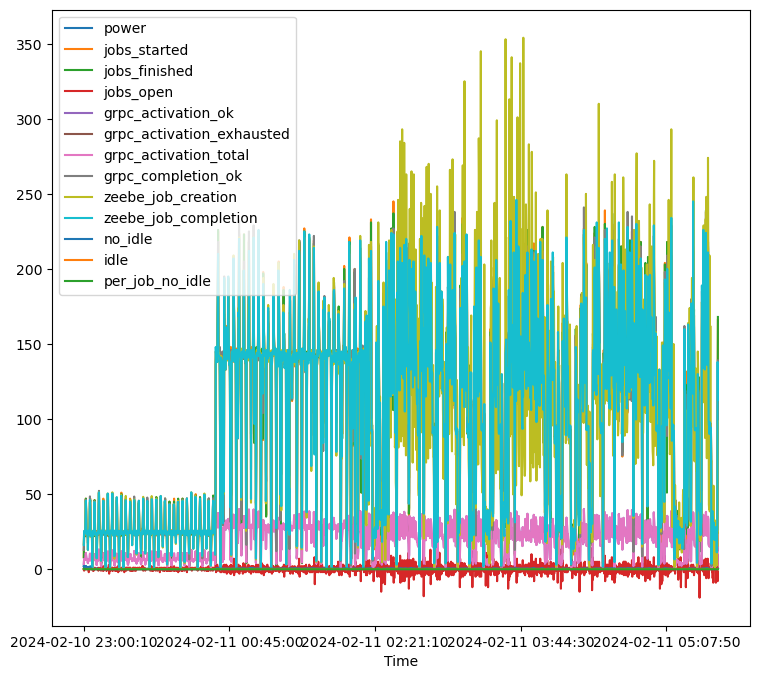

In [138]:
mja_8.plot(figsize=figsize)

In [139]:
mja_8.columns

Index(['power', 'jobs_started', 'jobs_finished', 'jobs_open',
       'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'no_idle', 'idle', 'per_job_no_idle'],
      dtype='object')

In [140]:
grpc_buckets, grpc_bucket_labels = create_buckets(all_sorted, 'grpc_activation_ok', 4)

mja_grpc_l = filter_outliers_iqr(group_by_bucket(mja_8, 'grpc_activation_ok', 'no_idle', grpc_buckets))
mja_grpc_m = filter_outliers_iqr(group_by_bucket(mja_64, 'grpc_activation_ok', 'no_idle', grpc_buckets))
mja_grpc_h = filter_outliers_iqr(group_by_bucket(mja_1024, 'grpc_activation_ok', 'no_idle', grpc_buckets))

In [141]:
job_buckets, job_buckets_labels = create_buckets(all_sorted, 'jobs_started', 20)

mja_grpc_internal_jobs_l = filter_outliers_iqr(group_by_bucket(mja_8, 'jobs_started', 'grpc_activation_ok', buckets))
mja_grpc_internal_jobs_m = filter_outliers_iqr(group_by_bucket(mja_64, 'jobs_started', 'grpc_activation_ok', buckets))
mja_grpc_internal_jobs_h = filter_outliers_iqr(group_by_bucket(mja_1024, 'jobs_started', 'grpc_activation_ok', buckets))

<Axes: title={'center': 'Jobs started over gRPC-Request: Job Activation, mja 1024'}>

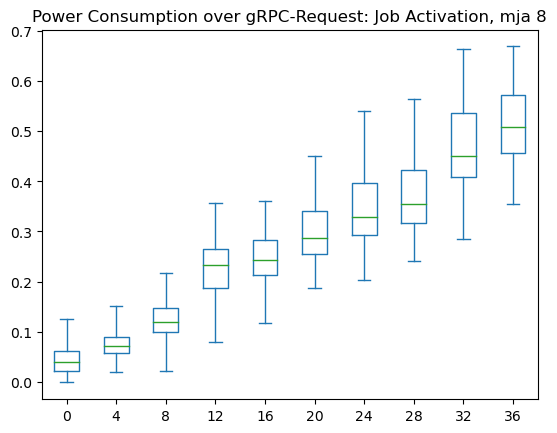

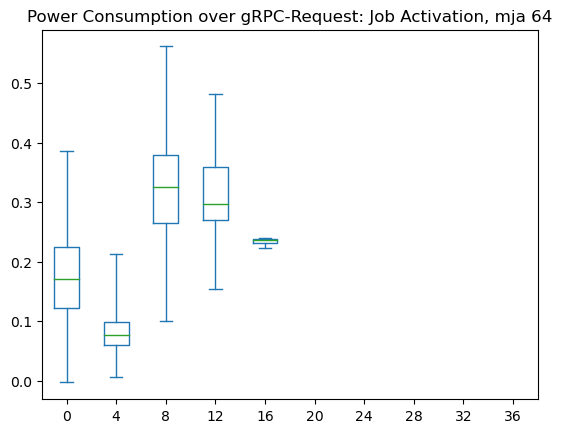

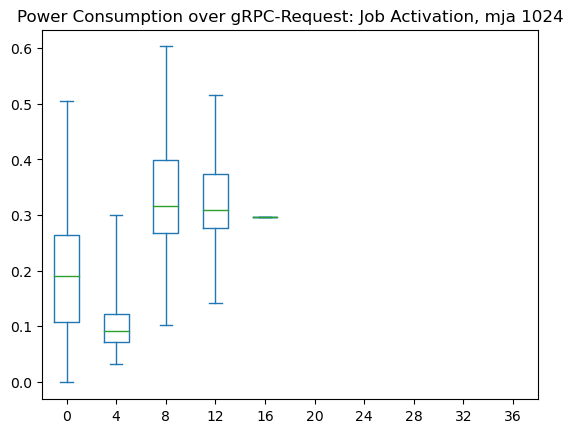

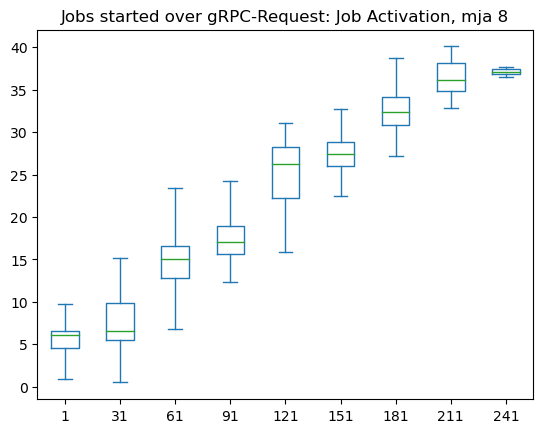

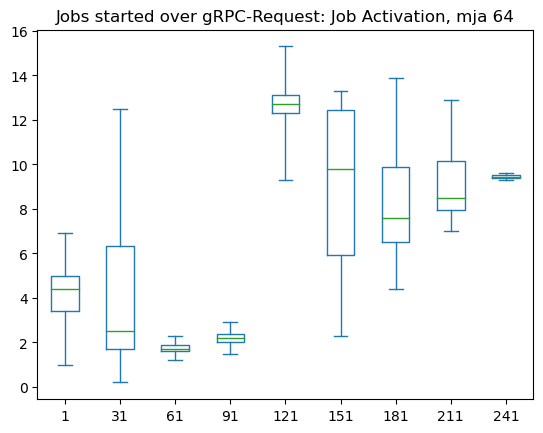

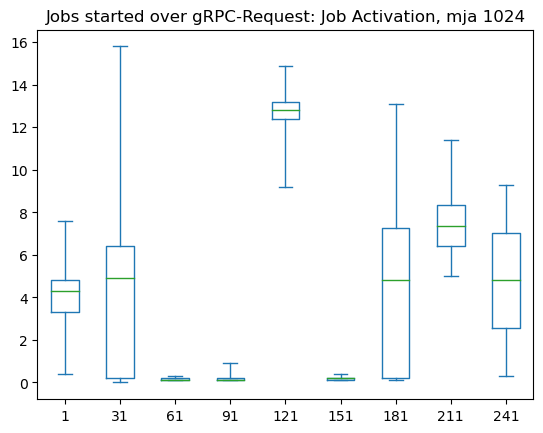

In [142]:
mja_grpc_l.plot(kind='box', whis=whis, title="Power Consumption over gRPC-Request: Job Activation, mja 8")
mja_grpc_m.plot(kind='box', whis=whis, title="Power Consumption over gRPC-Request: Job Activation, mja 64")
mja_grpc_h.plot(kind='box', whis=whis, title="Power Consumption over gRPC-Request: Job Activation, mja 1024")


mja_grpc_internal_jobs_l.plot(kind='box', whis=whis, title="Jobs started over gRPC-Request: Job Activation, mja 8")
mja_grpc_internal_jobs_m.plot(kind='box', whis=whis, title="Jobs started over gRPC-Request: Job Activation, mja 64")
mja_grpc_internal_jobs_h.plot(kind='box', whis=whis, title="Jobs started over gRPC-Request: Job Activation, mja 1024")

In [143]:
grpc_over_internal_jobs = pd.DataFrame()

grpc_over_internal_jobs['mja8'] = mja_grpc_internal_jobs_l.sum() * 10 / mja_grpc_internal_jobs_l.count()
grpc_over_internal_jobs['mja64'] = mja_grpc_internal_jobs_m.sum() * 10 / mja_grpc_internal_jobs_m.count()
grpc_over_internal_jobs['mja1024'] = mja_grpc_internal_jobs_h.sum() * 10 / mja_grpc_internal_jobs_h.count()

In [144]:
grpc_over_internal_jobs = pd.DataFrame()

grpc_over_internal_jobs['mja8'] = mja_grpc_internal_jobs_l.mean()
grpc_over_internal_jobs['mja64'] = mja_grpc_internal_jobs_m.mean()
grpc_over_internal_jobs['mja1024'] = mja_grpc_internal_jobs_h.mean()

In [145]:
# grpc_over_internal_jobs.plot(kind='bar')
grpc_over_internal_jobs

,mja8,mja64,mja1024
1,5.601957,4.239529,4.126923
31,7.338158,3.875000,4.445600
61,14.667164,1.737389,0.130268
91,17.390090,2.195122,0.177273
121,25.256891,12.680564,12.731962
151,27.517143,8.855882,0.174436
181,32.567521,8.226829,4.482857
211,36.400000,9.196296,7.455000
241,37.100000,9.450000,4.800000


#### Differenztabelle

<Axes: xlabel='power_8_64', ylabel='grpc_8_64'>

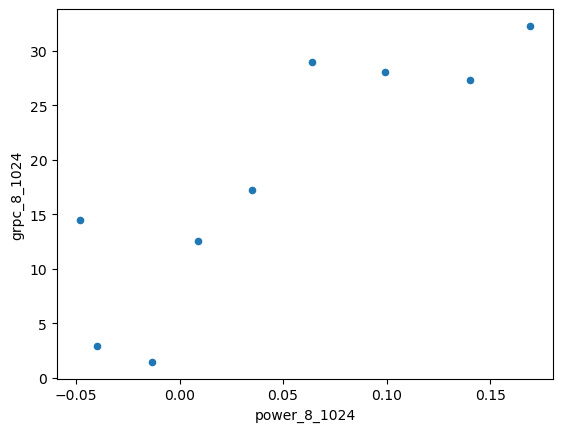

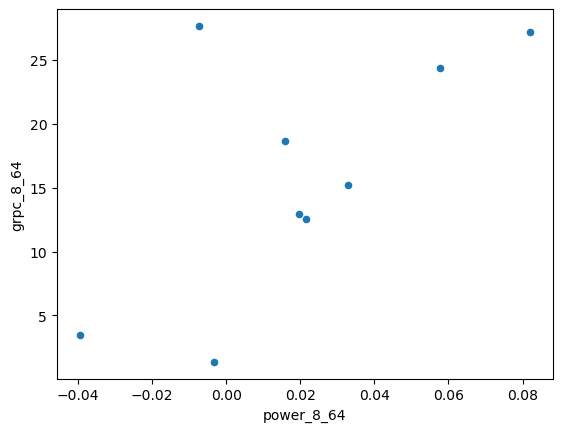

In [162]:
# Ankerpunkt: mja 8 nach Durchsatz
# 1) mittleren Durchsatz pro Bucket subtrahieren
# 2) mittlere grpc-Menge subtrahieren


hml_diff = pd.DataFrame()

hml_diff['power_8_1024'] = hml_median['mja8'] - hml_median['mja1024']
hml_diff['power_8_64'] = hml_median['mja8'] - hml_median['mja64']

hml_diff['grpc_8_1024'] = grpc_over_internal_jobs['mja8'] - grpc_over_internal_jobs['mja1024']
hml_diff['grpc_8_64'] = grpc_over_internal_jobs['mja8'] - grpc_over_internal_jobs['mja64']

# hml_diff

hml_diff.plot(kind='scatter', x= 'power_8_1024', y= 'grpc_8_1024')
hml_diff.plot(kind='scatter', x= 'power_8_64', y= 'grpc_8_64')

# ---

In [147]:
mja_8.columns

Index(['power', 'jobs_started', 'jobs_finished', 'jobs_open',
       'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'no_idle', 'idle', 'per_job_no_idle'],
      dtype='object')

<Axes: xlabel='grpc_activation_ok', ylabel='grpc_activation_exhausted'>

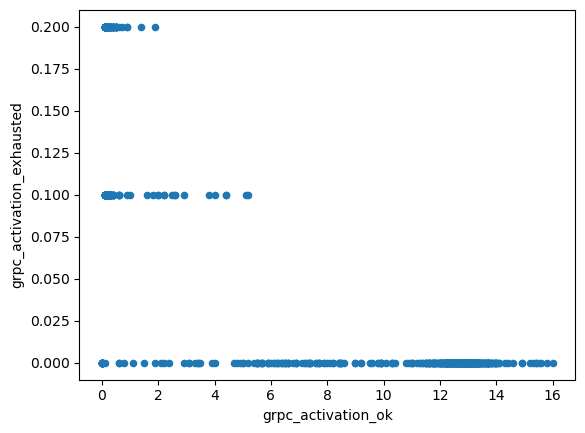

In [148]:
mja_1024.plot(kind='scatter', x='grpc_activation_ok', y='grpc_activation_exhausted')

<Axes: xlabel='Time'>

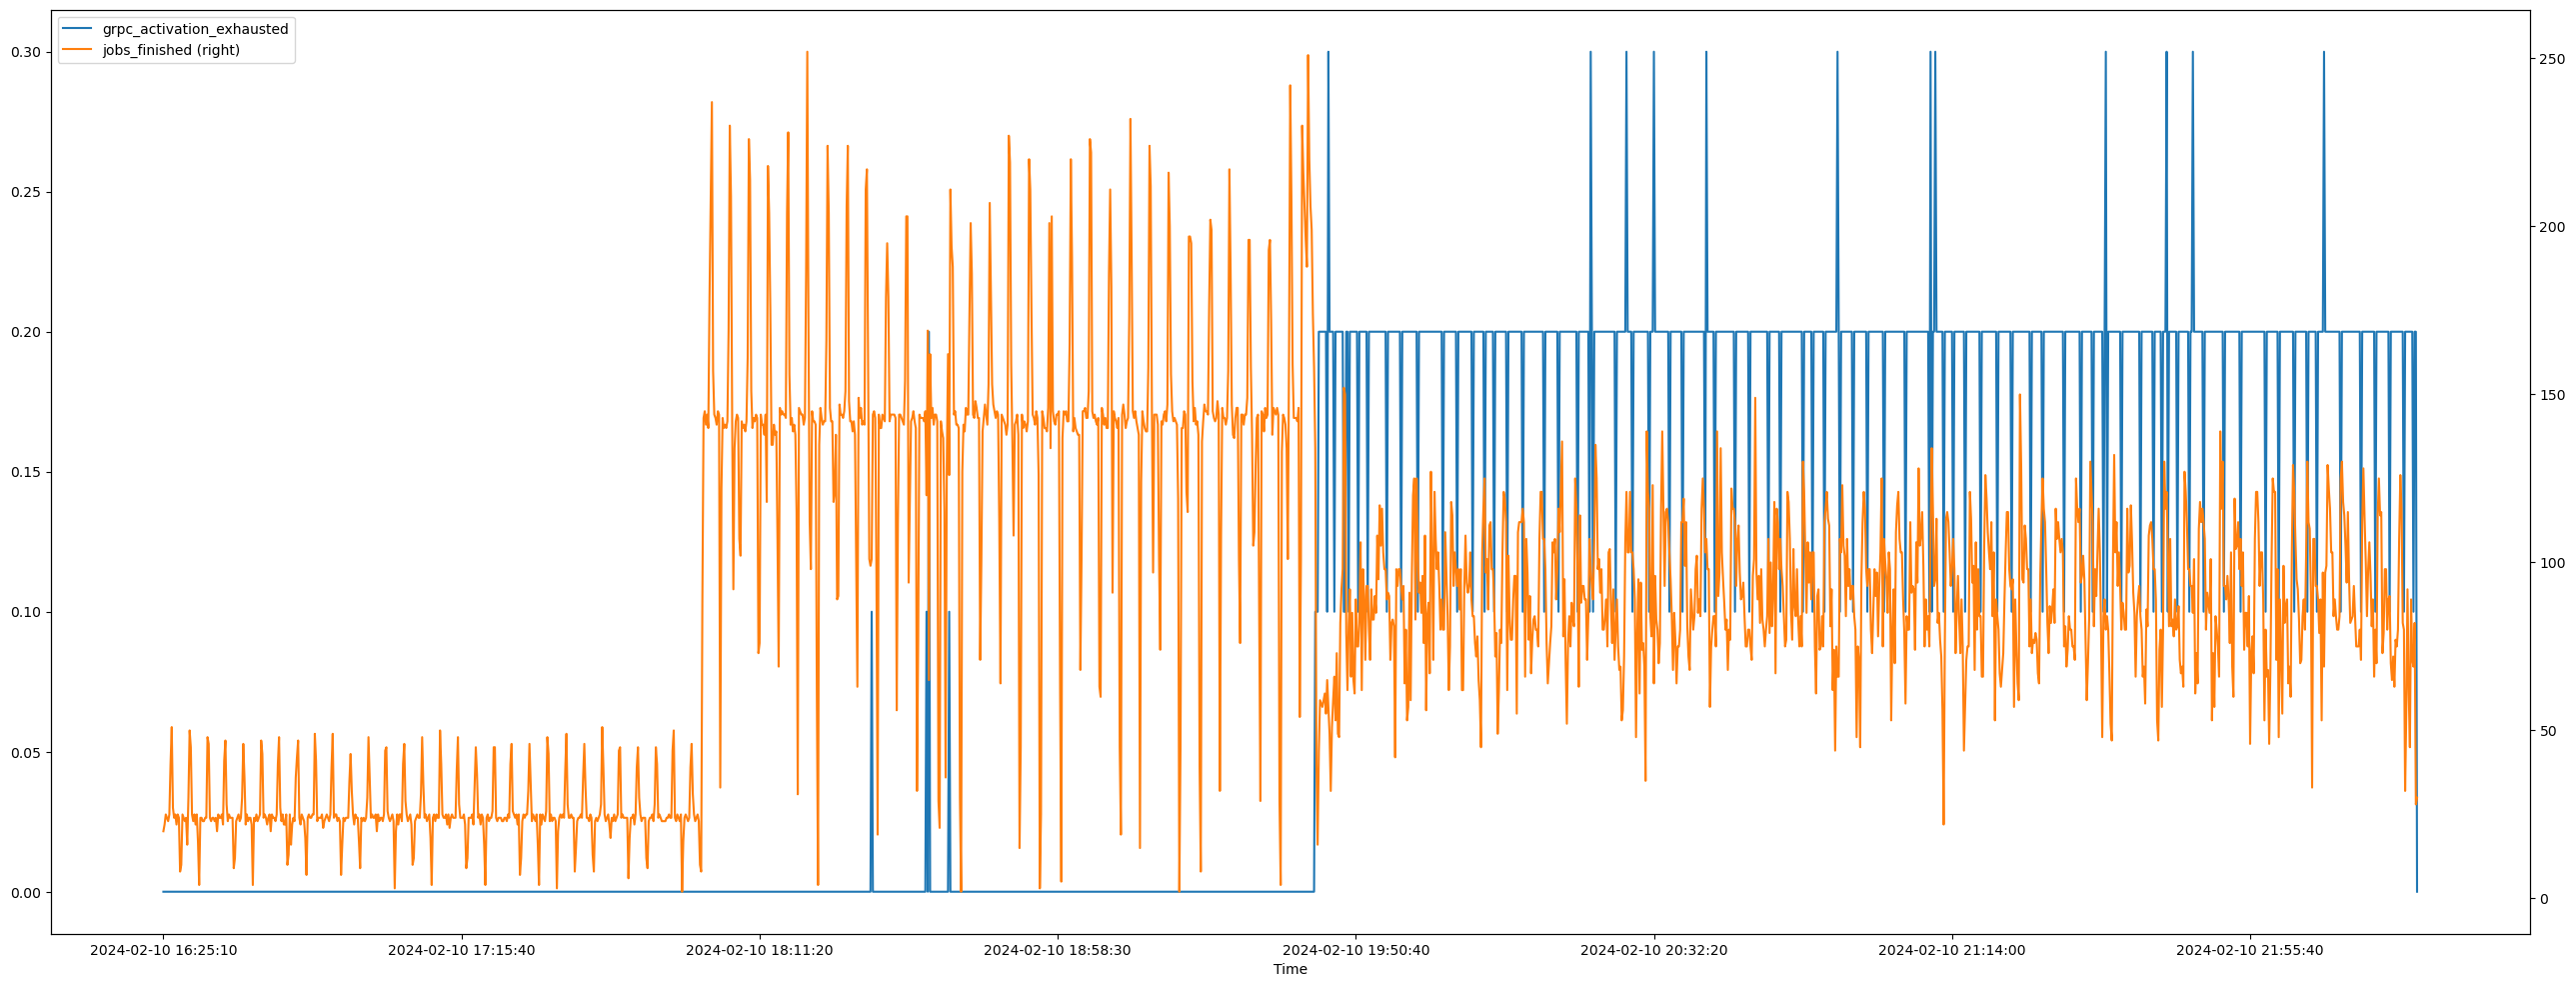

In [149]:
mja_64[['grpc_activation_exhausted','jobs_finished']].plot(secondary_y='jobs_finished', figsize= [32,12])

#### simplerer Ansatz

In [150]:
mja_8

,power,jobs_started,jobs_finished,jobs_open,grpc_activation_ok,grpc_activation_exhausted,grpc_activation_total,grpc_completion_ok,zeebe_job_creation,zeebe_job_completion,no_idle,idle,per_job_no_idle
Time,,,,,,,,,,,,,
2024-02-10 23:00:10,1.8522,8.0,8.0,0.0,3.4,0.0,3.4,12.8,16.8,16.1,1.7145,0.1377,0.214313
2024-02-10 23:00:20,1.1268,23.0,24.0,-1.0,6.8,0.0,6.8,24.1,24.8,25.5,0.9885,0.1383,0.042978
2024-02-10 23:00:30,2.1898,24.0,24.0,0.0,6.8,0.0,6.8,25.5,24.0,24.0,2.0045,0.1853,0.083521
2024-02-10 23:00:40,0.8228,24.0,24.0,0.0,6.4,0.0,6.4,22.5,24.9,23.4,0.6851,0.1377,0.028546
2024-02-10 23:00:50,0.5945,25.0,25.0,0.0,6.2,0.0,6.2,25.5,23.1,24.6,0.4562,0.1383,0.018248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-11 05:36:40,0.1989,19.0,19.0,0.0,3.1,0.2,3.3,19.0,2.5,11.2,0.0612,0.1377,0.003221
2024-02-11 05:36:50,0.1754,25.0,25.0,0.0,4.2,0.2,4.4,25.6,25.6,25.6,0.0371,0.1383,0.001484
2024-02-11 05:37:00,0.2278,22.0,12.0,10.0,4.3,0.2,4.5,26.2,15.2,26.2,0.0425,0.1853,0.001932


In [151]:
mja8_phase1 =  filter_outliers_iqr(mja_8.loc[:start_times_low[30],:])
mja8_phase2 =  filter_outliers_iqr(mja_8.loc[start_times_low[30]:start_times_low[60],:])

mja64_phase1 =  filter_outliers_iqr(mja_64.loc[:start_times_med[30],:])
mja64_phase2 =  filter_outliers_iqr(mja_64.loc[start_times_med[30]:start_times_med[60],:])

mja1024_phase1 =  filter_outliers_iqr(mja_1024.loc[:start_times_high[30],:])
mja1024_phase2 =  filter_outliers_iqr(mja_1024.loc[start_times_high[30]:start_times_high[60],:])

mja64_phase1 =  filter_outliers_iqr(mja64_phase1[(mja64_phase1['jobs_finished'] != 0) & (mja64_phase1['jobs_started'] != 0)])
mja64_phase2 =  filter_outliers_iqr(mja64_phase2[(mja64_phase2['jobs_finished'] != 0) & (mja64_phase2['jobs_started'] != 0)])

mja8_phase1 =  filter_outliers_iqr(mja8_phase1[(mja8_phase1['jobs_finished'] != 0) & (mja8_phase1['jobs_started'] != 0)])
mja8_phase2 =  filter_outliers_iqr(mja8_phase2[(mja8_phase2['jobs_finished'] != 0) & (mja8_phase2['jobs_started'] != 0)])

mja1024_phase1 = filter_outliers_iqr( mja1024_phase1[(mja1024_phase1['jobs_finished'] != 0) & (mja1024_phase1['jobs_started'] != 0)])
mja1024_phase2 = filter_outliers_iqr( mja1024_phase2[(mja1024_phase2['jobs_finished'] != 0) & (mja1024_phase2['jobs_started'] != 0)])


<Axes: xlabel='Time'>

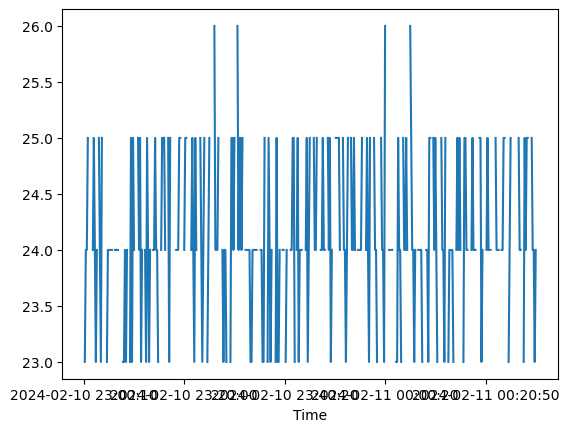

In [152]:
mja8_phase1['jobs_started'].plot()

In [153]:
total_power_comparison_start = pd.DataFrame()

total_power_comparison_start.loc['mja8-low','power'] = mja8_phase1['no_idle'].sum()
total_power_comparison_start.loc['mja8-low','time'] = len(mja8_phase1.index) / 6
total_power_comparison_start.loc['mja8-low','jobs_total'] = mja8_phase1['jobs_started'].sum()
total_power_comparison_start.loc['mja8-low','power_per_job'] = total_power_comparison_start.loc['mja8-low','power'] / total_power_comparison_start.loc['mja8-low','jobs_total']
total_power_comparison_start.loc['mja8-med','power'] = mja8_phase2['no_idle'].sum()
total_power_comparison_start.loc['mja8-med','time'] = len(mja8_phase2.index) / 6
total_power_comparison_start.loc['mja8-med','jobs_total'] = mja8_phase2['jobs_started'].sum()
total_power_comparison_start.loc['mja8-med','power_per_job'] = total_power_comparison_start.loc['mja8-med','power'] / total_power_comparison_start.loc['mja8-med','jobs_total']

total_power_comparison_start.loc['mja64-low','power'] = mja64_phase1['no_idle'].sum()
total_power_comparison_start.loc['mja64-low','time'] = len(mja64_phase1.index) / 6
total_power_comparison_start.loc['mja64-low','jobs_total'] = mja64_phase1['jobs_started'].sum()
total_power_comparison_start.loc['mja64-low','power_per_job'] = total_power_comparison_start.loc['mja64-low','power'] / total_power_comparison_start.loc['mja64-low','jobs_total']
total_power_comparison_start.loc['mja64-med','power'] = mja64_phase2['no_idle'].sum()
total_power_comparison_start.loc['mja64-med','time'] = len(mja64_phase2.index) / 6
total_power_comparison_start.loc['mja64-med','jobs_total'] = mja64_phase2['jobs_started'].sum()
total_power_comparison_start.loc['mja64-med','power_per_job'] = total_power_comparison_start.loc['mja64-med','power'] / total_power_comparison_start.loc['mja64-med','jobs_total']

total_power_comparison_start.loc['mja1024-low','power'] = mja1024_phase1['no_idle'].sum()
total_power_comparison_start.loc['mja1024-low','time'] = len(mja1024_phase1.index) /6
total_power_comparison_start.loc['mja1024-low','jobs_total'] = mja1024_phase1['jobs_started'].sum()
total_power_comparison_start.loc['mja1024-low','power_per_job'] = total_power_comparison_start.loc['mja1024-low','power'] / total_power_comparison_start.loc['mja1024-low','jobs_total']
total_power_comparison_start.loc['mja1024-med','power'] = mja1024_phase2['no_idle'].sum()
total_power_comparison_start.loc['mja1024-med','time'] = len(mja1024_phase2.index) / 6
total_power_comparison_start.loc['mja1024-med','jobs_total'] = mja1024_phase2['jobs_started'].sum()
total_power_comparison_start.loc['mja1024-med','power_per_job'] = total_power_comparison_start.loc['mja1024-med','power'] / total_power_comparison_start.loc['mja1024-med','jobs_total']


In [154]:
total_power_comparison_start

,power,time,jobs_total,power_per_job
mja8-low,28.2087,75.333333,7193.0,0.003922
mja8-med,163.8535,87.833333,47914.0,0.003420
mja64-low,28.3686,75.166667,8059.0,0.003520
mja64-med,147.5634,83.833333,46069.0,0.003203
mja1024-low,32.9646,75.166667,7967.0,0.004138
mja1024-med,149.9657,84.666667,44808.0,0.003347


In [155]:
total_power_comparison_stop = pd.DataFrame()

total_power_comparison_stop.loc['mja8-low','time'] = len(mja8_phase1.index) / 6
total_power_comparison_stop.loc['mja8-low','jobs_total'] = mja8_phase1['jobs_finished'].sum()
total_power_comparison_stop.loc['mja8-low','no_idle'] = mja8_phase1['no_idle'].median() * total_power_comparison_stop.loc['mja8-low', 'time']
total_power_comparison_stop.loc['mja8-low','power_per_job'] = total_power_comparison_stop.loc['mja8-low','no_idle'] / total_power_comparison_stop.loc['mja8-low','jobs_total']
total_power_comparison_stop.loc['mja8-low','power'] = mja8_phase1['power'].median() * total_power_comparison_stop.loc['mja8-low', 'time']
total_power_comparison_stop.loc['mja8-low','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja8-low','power'] / total_power_comparison_stop.loc['mja8-low','jobs_total']

total_power_comparison_stop.loc['mja8-med','time'] = len(mja8_phase2.index) / 6
total_power_comparison_stop.loc['mja8-med','jobs_total'] = mja8_phase2['jobs_finished'].sum()
total_power_comparison_stop.loc['mja8-med','no_idle'] = mja8_phase2['no_idle'].median() * total_power_comparison_stop.loc['mja8-med', 'time']
total_power_comparison_stop.loc['mja8-med','power_per_job'] = total_power_comparison_stop.loc['mja8-med','no_idle'] / total_power_comparison_stop.loc['mja8-med','jobs_total']
total_power_comparison_stop.loc['mja8-med','power'] = mja8_phase2['power'].median() * total_power_comparison_stop.loc['mja8-med', 'time']
total_power_comparison_stop.loc['mja8-med','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja8-med','power'] / total_power_comparison_stop.loc['mja8-med','jobs_total']

total_power_comparison_stop.loc['mja64-low','time'] = len(mja64_phase1.index) / 6
total_power_comparison_stop.loc['mja64-low','jobs_total'] = mja64_phase1['jobs_finished'].sum()
total_power_comparison_stop.loc['mja64-low','no_idle'] = mja64_phase1['no_idle'].median() * total_power_comparison_stop.loc['mja64-low', 'time']
total_power_comparison_stop.loc['mja64-low','power_per_job'] = total_power_comparison_stop.loc['mja64-low','no_idle'] / total_power_comparison_stop.loc['mja64-low','jobs_total']
total_power_comparison_stop.loc['mja64-low','power'] = mja64_phase1['power'].median() * total_power_comparison_stop.loc['mja64-low', 'time']
total_power_comparison_stop.loc['mja64-low','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja64-low','power'] / total_power_comparison_stop.loc['mja64-low','jobs_total']

total_power_comparison_stop.loc['mja64-med','time'] = len(mja64_phase2.index) / 6
total_power_comparison_stop.loc['mja64-med','jobs_total'] = mja64_phase2['jobs_finished'].sum()
total_power_comparison_stop.loc['mja64-med','no_idle'] = mja64_phase2['no_idle'].median() * total_power_comparison_stop.loc['mja64-med', 'time']
total_power_comparison_stop.loc['mja64-med','power_per_job'] = total_power_comparison_stop.loc['mja64-med','no_idle'] / total_power_comparison_stop.loc['mja64-med','jobs_total']
total_power_comparison_stop.loc['mja64-med','power'] = mja64_phase2['power'].median() * total_power_comparison_stop.loc['mja64-med', 'time']
total_power_comparison_stop.loc['mja64-med','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja64-med','power'] / total_power_comparison_stop.loc['mja64-med','jobs_total']

total_power_comparison_stop.loc['mja1024-low','time'] = len(mja1024_phase1.index) /6
total_power_comparison_stop.loc['mja1024-low','jobs_total'] = mja1024_phase1['jobs_finished'].sum()
total_power_comparison_stop.loc['mja1024-low','no_idle'] = mja1024_phase1['no_idle'].median() * total_power_comparison_stop.loc['mja1024-low', 'time']
total_power_comparison_stop.loc['mja1024-low','power_per_job'] = total_power_comparison_stop.loc['mja1024-low','no_idle'] / total_power_comparison_stop.loc['mja1024-low','jobs_total']
total_power_comparison_stop.loc['mja1024-low','power'] = mja1024_phase1['power'].median() * total_power_comparison_stop.loc['mja1024-low', 'time']
total_power_comparison_stop.loc['mja1024-low','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja1024-low','power'] / total_power_comparison_stop.loc['mja1024-low','jobs_total']

total_power_comparison_stop.loc['mja1024-med','time'] = len(mja1024_phase2.index) / 6
total_power_comparison_stop.loc['mja1024-med','jobs_total'] = mja1024_phase2['jobs_finished'].sum()
total_power_comparison_stop.loc['mja1024-med','no_idle'] = mja1024_phase2['no_idle'].median() * total_power_comparison_stop.loc['mja1024-med', 'time']
total_power_comparison_stop.loc['mja1024-med','power_per_job'] = total_power_comparison_stop.loc['mja1024-med','no_idle'] / total_power_comparison_stop.loc['mja1024-med','jobs_total']
total_power_comparison_stop.loc['mja1024-med','power'] = mja1024_phase2['power'].median() * total_power_comparison_stop.loc['mja1024-med', 'time']
total_power_comparison_stop.loc['mja1024-med','power_per_job_with_idle'] = total_power_comparison_stop.loc['mja1024-med','power'] / total_power_comparison_stop.loc['mja1024-med','jobs_total']


In [156]:
total_power_comparison_stop

,time,jobs_total,no_idle,power_per_job,power,power_per_job_with_idle
mja8-low,75.333333,7344.0,5.137733,0.000700,16.030933,0.002183
mja8-med,87.833333,47667.0,28.699542,0.000602,40.693183,0.000854
mja64-low,75.166667,8050.0,5.216567,0.000648,16.115733,0.002002
mja64-med,83.833333,43951.0,25.384733,0.000578,37.276492,0.000848
mja1024-low,75.166667,7931.0,5.960717,0.000752,16.874917,0.002128
mja1024-med,84.666667,45402.0,26.204333,0.000577,38.150800,0.000840


In [157]:
mja_8.columns

Index(['power', 'jobs_started', 'jobs_finished', 'jobs_open',
       'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'no_idle', 'idle', 'per_job_no_idle'],
      dtype='object')

<Axes: xlabel='Time'>

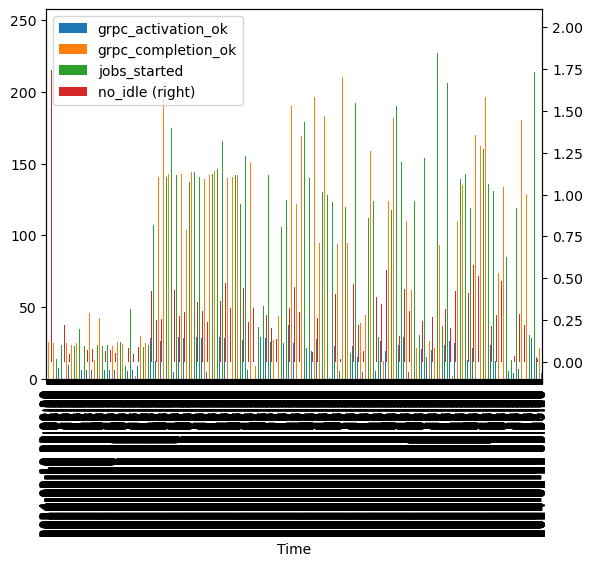

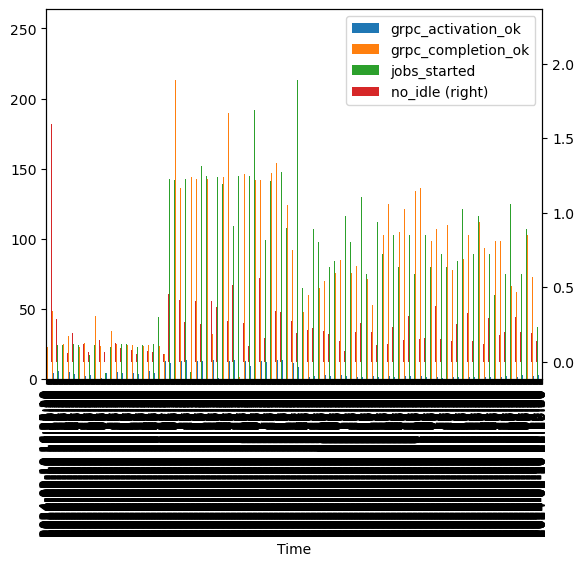

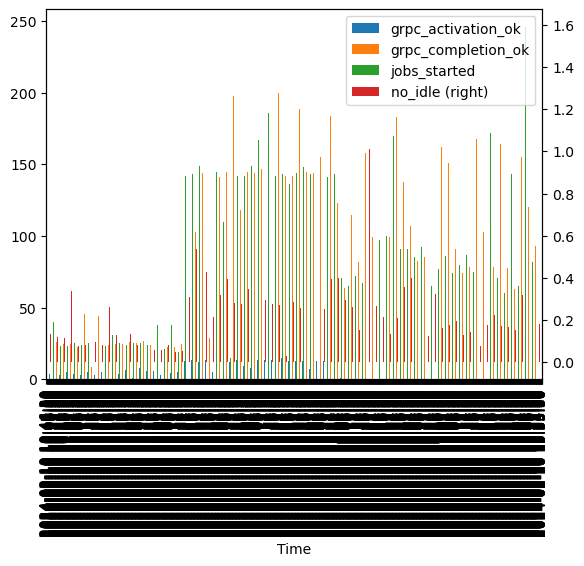

In [158]:
mja_8[['grpc_activation_ok','grpc_completion_ok','jobs_started', 'no_idle']].plot(kind='bar', secondary_y='no_idle')
mja_64[['grpc_activation_ok','grpc_completion_ok','jobs_started', 'no_idle']].plot(kind='bar', secondary_y='no_idle')
mja_1024[['grpc_activation_ok','grpc_completion_ok','jobs_started', 'no_idle']].plot(kind='bar', secondary_y='no_idle')

### individueller Phasenvergeich

In [159]:
mja8_l_buckets, mja8_l_bucket_labels = create_buckets(mja8_phase1,'jobs_finished',4)

mja8_l_clean = winsorize(group_by_bucket(mja8_phase1,'jobs_finished','no_idle', mja8_l_buckets),'no_idle', limits=0.05)


TypeError: winsorize() got multiple values for argument 'limits'

### Plot Result

In [ ]:
# define Colors

lightgreen = "#6ccbb2"
green = "#437e6e"
darkblue = "#90c5e2"
blue = "#a2d8ff"
black = "#1f1f1f"
grey = "#f3f3f2"
white = "#ffffff"

In [ ]:
figsize = [15,5]

ax = cap_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Energy Consumption per Job",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]"
)
ax.set_xticklabels(xlabels)

NameError: name 'cap_clean' is not defined

In [ ]:
ax = total_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Total Energy Consumption",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]"
)
ax.set_xticklabels(xlabels)

total_clean

In [ ]:
cap_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title='Median of Energy consumption per Job'
)

min_med = cap_clean.median(axis=0).min()
max_med = cap_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)

In [ ]:
total_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title="Median of total Energy Consumption"
)

min_med = total_clean.median(axis=0).min()
max_med = total_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)
print(idle_pattern.mean().mean())
print(total_clean.median(axis=0))


In [ ]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[8,7])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        color= blue, 
        width=9,
        label='Median Energy Consumption'
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Median Total Energy Consumption [W/10s]', color=black)
ax1.legend(loc='upper right')

ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job', 
         color=black,
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Median Energy Consumption per Job [W/10s]')
ax2.legend(loc='upper left')
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,0.005)

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

In [ ]:
idle_grouped

In [ ]:
temp = pd.DataFrame()
temp['total'] = total_clean.median().reset_index(drop=True)
temp['idle'] = idle_grouped.mean(skipna=True).reset_index(drop=True)
# temp['per_worker'] = cap_clean.median().reset_index(drop=True)

# Reverse the order of columns
temp = temp[temp.columns[::-1]]

temp.index = xlabels
print(temp.dtypes)
ax1 = temp.plot(
    figsize=[8,7],
    kind='bar',
    stacked=True,
    color=[green,blue],
    width=0.9,
    title="Energy Consumption for Troughput Stacked on Median Idle Consumption",
    xlabel="Throughput [Jobs/s]",
    ylabel="Energy Consumption [W/10s]"
)

In [ ]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[14,12])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        label='Median Total Energy Consumption [J] (left)', 
        color= blue, 
        alpha=0.7,
        width=9, 
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Bars: Median Total Energy Consumption [J]', color=black)
ax1.legend(loc='upper right')
print(xlabels)
ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job [J] (right)', 
         color=black
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Line: Median Energy Consumption per Job [J]')
ax2.set_ylim(0,0.005)
ax1.set_ylim(0,0.5)
ax2.legend(loc='upper left')

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

In [ ]:
# Plot completion and power as time series
figsize= [24,6]


# Plotting
ax = completion_and_power['power'].plot(
    kind='bar',
    width=1,
    alpha=0.8,
    color= blue, 
    label='Energy Consumption',
    ylim=[0,0.9],
    xticks=None,
    figsize=figsize
    )

ax.set_ylabel('Energy Consumption Worker [W/10s]')

# Create secondary y-axis
ax2 = ax.twinx()
completion_and_power['completion'].plot(
    ax=ax2, 
    color=black, 
    label='Job Completion',
    xticks=None,
    secondary_y=True)
ax2.set_ylabel('Job Completion [1/s]')

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [ ]:
# raw plot

raw_plot = pd.DataFrame(worker_power.loc['2024-02-05 21:01:00':,:])
raw_plot['completion'] = worker_jobs

raw_plot.plot(secondary_y='completion', color=[black, blue, lightgreen, green], figsize=[30,10])

In [ ]:
# create Table with Key Indicators

indicators = pd.DataFrame(columns = ['Energieverbrauch', 'Durchsatz'])

indicators.loc['Minimum', 'Energieverbrauch'] = completion_and_power['power'].min()
indicators.loc['Maximum', 'Energieverbrauch'] = completion_and_power['power'].max()
indicators.loc['Minimum', 'Durchsatz'] = completion_and_power['completion'].min()
indicators.loc['Maximum', 'Durchsatz'] = completion_and_power['completion'].max()

indicators

---
### Messvorbereitung

Zeebe Dashboard importieren
Skript vorbereiten (Prozessname, Array, etc)
Prozess deployen
Zeebe Port-Forwarding
Timestamp setzen

### Messnachbereitung

Grafana CSV-Export

### ToDo

Skript ändern, so dass Logs Startzeitpunkte in 1 File schreiben
Modulo in shellskript-methode anpassen weil alter scrape intervall war 10sek, jetzt sinds 30Sek

### Notizen

Startzeitpunkt: 2024-02-01 11:40:00 
Modell: load_generator_120j_in_60s

maxjobsactive: 32
pollinterval: 2 # seconds before polling again
timeout: 45
requestTimeout: 30 # how long to keep a request open

---
